# Predição da Qualidade do Vinho

## Análise de Dados e Modelagem com PyTorch e Scikit-Learn

Arthur Cardoso 211038191
Artur Padovesi 211038208

In [199]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset


In [200]:
data = pd.read_csv('winequalityN.csv')
data

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## Início do Tratamento dos Dados

Antes de prosseguir com a modelagem, é necessário realizar o tratamento dos dados para garantir que estejam prontos para análise. Na célula abaixo, realizamos a codificação da variável categórica `type` utilizando `LabelEncoder`, transformando-a em valores numéricos. Além disso, verificamos a existência de valores nulos no conjunto de dados e removemos as linhas que possuem valores faltantes, garantindo a integridade dos dados para as próximas etapas.


In [201]:
# Encoding type of wine
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])

print(data.isnull().sum())

# remover linhas que possuem valores faltantes
data.dropna(inplace=True)

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


## Separação e Normalização dos Dados

Dividimos o conjunto de dados em três partes: treinamento, validação e teste, utilizando a função `train_test_split` do `sklearn.model_selection`. Após a separação, normalizamos as features (exceto a coluna `quality`) utilizando o `MinMaxScaler` do `sklearn.preprocessing`, garantindo que os valores estejam entre 0 e 1. Essa etapa é essencial para melhorar a performance do modelo durante o treinamento.


In [202]:
# Split the into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

x_train, y_train = train_data.drop(columns=['quality']), train_data['quality']
x_val, y_val = val_data.drop(columns=['quality']), val_data['quality']
x_test, y_test = test_data.drop(columns=['quality']), test_data['quality']


# Normalizar as features (exceto a coluna 'quality')
scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_val = pd.DataFrame(scaler.transform(x_val), columns=x_val.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)


# Convert to PyTorch tensors
X_train, Y_train = torch.tensor(x_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
train_ds = TensorDataset(X_train, Y_train)

X_val, Y_val = torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32)
val_ds = TensorDataset(X_val, Y_val)

X_test, Y_test = torch.tensor(x_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

n_features = X_val.shape[1]
n_features

12

## Treinamento do Modelo com a Classe `LinearRegression`

Nesta etapa, treinamos um modelo de regressão linear simples utilizando a classe `LinearRegression`. O modelo possui uma camada linear com pesos e bias inicializados aleatoriamente. O treinamento é realizado com o otimizador SGD e a função de perda L1, ajustando os pesos para minimizar o erro entre as predições e os valores reais. As perdas de treinamento e validação são registradas para análise.


In [203]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=n_features, out_features=1)  # 'n_features' entradas, 1 saída
        nn.init.normal_(self.linear.weight, mean=0, std=0.01)
        nn.init.zeros_(self.linear.bias)

    def forward(self, X):
        return self.linear(X)

def get_loss_fn():
    # return nn.L1Loss()
    return nn.MSELoss()

def get_optimizer(model, lr):
    return optim.SGD(model.parameters(), lr=lr)

In [204]:
model = LinearRegression()
loss_fn = get_loss_fn()
optimizer = get_optimizer(model, lr=1e-3)

num_epochs = 100

val_losses = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    for X_batch, Y_batch in train_loader:
        preds = model(X_batch)
        loss = loss_fn(preds, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = loss_fn(model(X_val), Y_val.reshape(len(Y_val), 1))
        train_loss = loss_fn(model(X_train), Y_train.reshape(len(Y_train), 1))
    val_losses.append(val_loss)
    train_losses.append(train_loss)
        # val_loss = sum(loss_fn(model(X_val), torch.tensor(y_val))) / len(y_val)
    # print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


<ipython-input-205-fac26c13c011>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


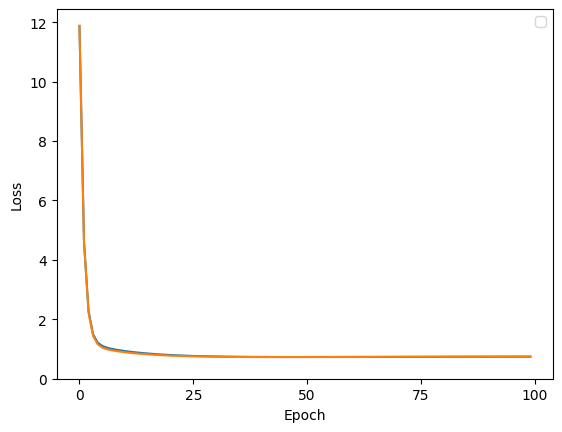

In [205]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.linspace(0, num_epochs, 5))
# plt.xticks(np.arange(0, num_epochs))
plt.legend()
plt.plot(val_losses, label="Validation Loss")
plt.plot(train_losses, label="Training Loss")
# plt.xlim(0, 10)
plt.ylim(bottom=0)
plt.show()

## Análise de Parâmetros

Nesta etapa, iremos explorar diferentes medidas para buscar um modelo simplificado com performance igual ou melhor ao modelo com todos os parâmetros. Essa análise pode ser útil para identificar colunas redundantes ou altamente correlacionadas, que podem ser removidas ou tratadas para evitar multicolinearidade nos modelos.

Ao olhar os pesos do modelo treinado, é possível notar o quão relevantes os parâmetros estão sendo para obtenção do resultado final. Quanto maior o peso, geralmente maior é o impacto da variável no resultado do modelo.

In [206]:
inp_names = list(data.columns)[0:-1]
inp_w_values = model.linear.weight.detach().numpy().reshape((len(inp_names),))
w_df = pd.Series(inp_w_values, index=x.columns).sort_values(ascending=False)
w_df

,0
pH,1.284728
fixed acidity,1.139299
volatile acidity,0.980260
alcohol,0.792334
sulphates,0.697803
density,0.675744
type,0.548863
citric acid,0.543309
chlorides,0.454583
total sulfur dioxide,0.390408


A distribuição dos dados também deve ser considerada ao interpretar os pesos que os dados têm. Uma distribuição que não é normal, uniforme ou somente não simétrica pode fazer com que o peso tenda a valores menores ou maiores sem necessariamente ter a ver com o quanto o dado é relevante para classificação.

De forma simplificada, pela mediana é possível entender um pouco como os dados se distribuem, pois 50% dos dados é menor, e 50% maior do que a mediana.

No caso estudado, pH e alcohol parecem ter as medianas mais próximas da metade do range normalizado, e portanto são as que o treinamento do modelo provavelmente converge mais rápido ao utilizar. Além disso, o impacto outras das variáveis provavelmente é superestimado ao olhar somente os pesos.

In [207]:
medians = np.median(scaler.transform(x), axis=0)
median_df = pd.Series(medians, index=x.columns).sort_values(ascending=False)
median_df

,0
type,1.000000
pH,0.405172
alcohol,0.333333
total sulfur dioxide,0.258065
fixed acidity,0.239316
citric acid,0.186747
volatile acidity,0.168000
sulphates,0.162921
density,0.149990
free sulfur dioxide,0.097222


In [208]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

x, y = data.drop(columns=['quality']), data['quality']

mi = mutual_info_regression(x, y, random_state=0)
# mi = mutual_info_classif(x, y, random_state=0)
mi_df = pd.Series(mi, index=x.columns).sort_values(ascending=False)
mi_df

,0
alcohol,0.160126
density,0.149433
total sulfur dioxide,0.067258
chlorides,0.066973
residual sugar,0.053237
citric acid,0.051566
volatile acidity,0.043367
free sulfur dioxide,0.040078
sulphates,0.011959
fixed acidity,0.007244


## Um segundo modelo

A partir de testes experimentais, retirando as variáveis que pareciam ser menos relevantes, o conjunto de features com apenas  alcohol se mostrou melhor do que o modelo que se utiliza de todos os parâmetros e até do que se utiliza de pH e alcohol.

Esse modelo reduzido se apresenta a seguir.

In [209]:
columns_to_drop = [
    # "alcohol",

    "pH",
    "total sulfur dioxide",
    "type",
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "sulphates",
]


x_train_sm = x_train.drop(columns=columns_to_drop)
x_val_sm = x_val.drop(columns=columns_to_drop)
x_test_sm = x_test.drop(columns=columns_to_drop)

# Convert to PyTorch tensors
X_train_sm, Y_train_sm = torch.tensor(x_train_sm.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
train_ds = TensorDataset(X_train_sm, Y_train_sm)

X_val_sm, Y_val_sm = torch.tensor(x_val_sm.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32)
val_ds = TensorDataset(X_val_sm, Y_val_sm)

X_test_sm, Y_test_sm = torch.tensor(x_test_sm.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

n_features = X_val_sm.shape[1]
n_features

1

## Re-treinamento do Modelo

Nesta etapa, realizaremos o re-treinamento do modelo utilizando os dados ajustados. O objetivo é verificar se a remoção de colunas altamente correlacionadas ou redundantes, como `total sulfur dioxide`, pode melhorar o desempenho do modelo. O processo de treinamento será semelhante ao anterior, com a mesma arquitetura de modelo, função de perda e otimizador, mas agora utilizando o conjunto de dados modificado.

In [210]:
model2 = LinearRegression()
loss_fn = get_loss_fn()
optimizer = get_optimizer(model2, lr=1e-3)

num_epochs = 100

val_losses = []
train_losses = []

for epoch in range(num_epochs):
    model2.train()
    for X_batch, Y_batch in train_loader:
        preds = model2(X_batch)
        loss = loss_fn(preds, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model2.eval()
    with torch.no_grad():
        val_loss = loss_fn(model2(X_val_sm), Y_val_sm)
        train_loss = loss_fn(model2(X_train_sm), Y_train_sm)
    val_losses.append(val_loss)
    train_losses.append(train_loss)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1034])) that is different to the input size (torch.Size([1034, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

<ipython-input-211-fac26c13c011>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


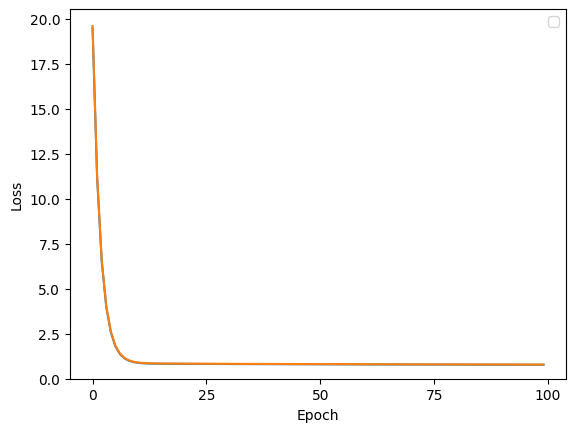

In [211]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.linspace(0, num_epochs, 5))
# plt.xticks(np.arange(0, num_epochs))
plt.legend()
plt.plot(val_losses, label="Validation Loss")
plt.plot(train_losses, label="Training Loss")
# plt.xlim(0, 10)
plt.ylim(bottom=0)
plt.show()

## Resultados

Um preditor trivial será utilizado para comparação, onde a média da qualidade do vinho será usada como predição sempre.

Os trẽs modelos podem então ter sua performance comparada por Mean Absolute Error, Mean Squared Error, Acurácia, Correlação com saída verdadeira e Kendall tau.

Kendall tau é uma medida de correlação de postos. Quanto melhor o modelo manter a ordem de qualidade entre os pares, maior seu valor é.

In [212]:
# Preditor trivial: atribuir o valor médio de 'quality' como predição
mean_quality = y_train.mean()
trivial_preds = torch.full_like(Y_test, mean_quality, dtype=torch.float32)

In [213]:
from scipy.stats import kendalltau

y_pred = model(X_test)
y2_pred = model2(X_test_sm)
loss = loss_fn(y_pred, Y_test)
loss2 = loss_fn(y2_pred, Y_test_sm)
loss_trivial = loss_fn(trivial_preds, Y_test)

print(f"Loss do preditor trivial: {loss_trivial:.2f}")
print(f"Loss do modelo inicial: {loss:.2f}")
print(f"Loss do modelo reduzido: {loss2:.2f}")

Loss do preditor trivial: 0.79
Loss do modelo inicial: 0.85
Loss do modelo reduzido: 0.82


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1293])) that is different to the input size (torch.Size([1293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [214]:
# Calcular o erro médio quadrático (MSE) de todos
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Y_test.numpy(), y_pred.detach().numpy())
mse2 = mean_squared_error(Y_test_sm.numpy(), y2_pred.detach().numpy())
trivial_mse = mean_squared_error(Y_test.numpy(), trivial_preds.numpy())

# Exibir os resultados
print(f"Erro Quadrático Médio (MSE) do preditor trivial: {trivial_mse:.2f}")
print(f"Erro Quadrático Médio (MSE) do modelo inicial: {mse:.2f}")
print(f"Erro Quadrático Médio (MSE) do modelo reduzido: {mse2:.2f}")

Erro Quadrático Médio (MSE) do preditor trivial: 0.79
Erro Quadrático Médio (MSE) do modelo inicial: 0.77
Erro Quadrático Médio (MSE) do modelo reduzido: 0.66


In [215]:
# Calcular o erro médio absoluto (MAE) de todos
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(Y_test.numpy(), y_pred.detach().numpy())
mae2 = mean_absolute_error(Y_test_sm.numpy(), y2_pred.detach().numpy())
trivial_mae = mean_absolute_error(Y_test.numpy(), trivial_preds.numpy())

# Exibir os resultados
print(f"Erro Médio Absoluto (MAE) do preditor trivial: {trivial_mae:.2f}")
print(f"Erro Médio Absoluto (MAE) do modelo inicial: {mae:.2f}")
print(f"Erro Médio Absoluto (MAE) do modelo reduzido: {mae2:.2f}")

Erro Médio Absoluto (MAE) do preditor trivial: 0.71
Erro Médio Absoluto (MAE) do modelo inicial: 0.69
Erro Médio Absoluto (MAE) do modelo reduzido: 0.64


In [216]:
# Calcular a acurácia do modelo
y_pred_classes = torch.round(y_pred).squeeze()  # Arredondar as predições para o inteiro mais próximo
model_accuracy = (y_pred_classes == Y_test).float().mean().item() * 100

y_pred_classes_sm = torch.round(y2_pred).squeeze()  # Arredondar as predições para o inteiro mais próximo
model_accuracy_sm = (y_pred_classes_sm == Y_test_sm).float().mean().item() * 100

# Calcular a acurácia do preditor trivial
trivial_accuracy = (torch.round(trivial_preds) == Y_test).float().mean().item() * 100

# Calcular a acurácia do preditor aleatório
random_preds = torch.randint(1, 8, Y_test.shape)  # Gerar predições aleatórias entre 1 e 7
random_accuracy = (random_preds == Y_test).float().mean().item() * 100

# Exibir os resultados
print(f"Acurácia do preditor trivial: {trivial_accuracy:.2f}%")
print(f"Acurácia do preditor aleatório: {random_accuracy:.2f}%")
print(f"Acurácia do modelo inicial: {model_accuracy:.2f}%")
print(f"Acurácia do modelo reduzido: {model_accuracy_sm:.2f}%")

Acurácia do preditor trivial: 41.76%
Acurácia do preditor aleatório: 13.15%
Acurácia do modelo inicial: 42.92%
Acurácia do modelo reduzido: 41.76%


In [217]:
# Calcular a correlação entre a saída desejada (Y_test) e a saída obtida (y_pred)
correlation = np.corrcoef(Y_test.numpy(), y_pred.detach().numpy().flatten())[0, 1]

# Exibir o resultado
print(f"Correlação entre saída desejada e obtida do modelo inicial: {correlation:.2f}")
# Calcular a correlação entre a saída desejada (Y_test) e a saída obtida (y_pred)
correlation = np.corrcoef(Y_test_sm.numpy(), y2_pred.detach().numpy().flatten())[0, 1]

# Exibir o resultado
print(f"Correlação entre saída desejada e obtida do modelo reduzido: {correlation:.2f}")

Correlação entre saída desejada e obtida do modelo inicial: 0.18
Correlação entre saída desejada e obtida do modelo reduzido: 0.51


In [218]:
# kendalltau é uma medida de correlação que compara a ordem relativa de cada par de pontos, desconsiderando a magnitude
# ou seja, quanto melhor nossa predição manter a ordem dos ranques, maior o valor de tau
tau, _ = kendalltau(y_test, y_pred.detach().numpy())
tau2, _ = kendalltau(y_test, y2_pred.detach().numpy())
print(f"Kendall's Tau do modelo inicial: {tau:.2f}")
print(f"Kendall's Tau do modelo reduzido: {tau2:.2f}")

Kendall's Tau do modelo inicial: 0.15
Kendall's Tau do modelo reduzido: 0.40


## Conclusão

O modelo de regressão linear apresentou sua limitação em classificação ao mostrar extrema sensibilidade a ruído, mostrando melhor performance ao manter somente uma feature.

Mesmo esse modelo não apresenta performance muito superior ao preditor trivial, estando longe de uma performance aceitável de predição de qualidade de vinho.

Os objetivos desse projeto foram concluídos, com a exploração do modelo de regressão linear e a visualização de sua limitação.